<a href="https://colab.research.google.com/github/zip37/garrulous-octo-kumquat/blob/master/E2_alberto_flores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Código para el examen 2**
**Alberto Flores Cruz**

Librerías iniciales

In [550]:
import numpy as np
import matplotlib.pyplot as plt

Implementaremos un solver de DG basado en el artículo de Cockburn y Shu. 

El problema a resolver es de una ley de conservación dada por

$$u_t + (f(u))_x = 0$$

donde $f$ puede ser no-lineal.

Recordemos que al discretizar usando DG se obtiene el sistema de ecuaciones

$$MU_t = \hat L(U)$$

La matriz de masa obtenida es diagonal por bloques, debido a esto, es fácil de invertir y podemos escribir:

$$U_t = M^{-1} \hat L(U) = L(U)$$

Nos enfocaremos en escribir $L(U)$ de manera que pueda ser utilizado en la implementación del método RK.

Recordemos que al usar como base para cada elemento a los polinomios de Legendre, es posible aprovechar su ortogonalidad, ya que estos satisfacen

$$\int_{I_k} \phi_\mathcal{l} \phi_{\mathcal{l}'} = \frac{\Delta x_k}{2\mathcal{l} +  1}$$

Cuando sus grados son $l = l'$. Esto nos permite expresar a $M$ como una matriz diagonal y nos preocupamos por escribir sólamente a $L$. El esquema numérico está dado entonces por:

$$\frac{d}{dt} u_j^l(t) = \frac{2l+1}{\Delta x_j} \int_{I_j} f(u_h(x,t))( \phi ^j_l(x) )_x \, dx - \hat f (u_h(x,t))\phi_l^j \rvert_{x_{j-\frac12}}^{x_{j+\frac12}}$$

El flujo numérico elegido para $\hat f$ es el de Lax-Friedrichs. 

In [676]:
#Funciones base
def phi(x,degree):
    if degree==0:
      return 1.0
    elif degree==1:
      return x
    elif degree==2:
      return 1.5*x**2-0.5
    elif degree==3:
      return 2.5*x**3-1.5*x
    else: 
      return 0

def phi_derivative(x,degree):
    if degree==0:
      return 0.0
    elif degree==1:
      return 1.0
    elif degree==2:
      return 3.0*x
    elif degree==3:
      return 7.5*x**2-1.5
    else:
      return 0

#Flujo Lax-Friedrichs
def Nf_LF(f,Df,a,b,n): #Numerical flux, notice dependence on the "normal"
    C=max(np.abs(Df(a)),np.abs(Df(b)))
    y=0.5*((f(a)+f(b))*n-C*(b-a))
    return y

#Flujo Godunov
def Nf_G(f,Df,a,b,n):
  return min(f(a),f(b))

def L(f,Df,flux,u_0,I,degree):
  np.seterr("raise")
  N = len(I)
  epsilon = 1e-6
  L_mat = np.zeros((N-1,degree+1))
  integration_points = int(np.ceil((degree+1)/2))
  weights = q_weights(integration_points)
  points = q_points(integration_points)
  
  for cell in range(N-1):
    
    P1 = I[cell]
    P2 = I[cell+1]

    dx = P2 - P1
    xj = 0.5*(P1+P2)
    
    for l in range(degree+1):
      #Integracion por cuadratura gaussiana
      quadrature = 0.0
      
      for i in range(integration_points):
        increment = 0.0
        for j in range(degree+1):
          increment = increment + u[cell][j] * phi(points[i],j)
        fu = f(increment)
        increment = weights[i]*phi_derivative(points[i],l)*fu
        quadrature = quadrature + increment
      
      #print("quadrature",quadrature)
      #Calculo de flujos numéricos
      P2_l = u_reconstruct(P2-epsilon,I,u,degree)
      if cell == N-2 :
        P2_r = u_reconstruct(P2,I,u,degree)
      else :
        P2_r = u_reconstruct(P2+epsilon,I,u,degree)
      if cell == 0:
        P1_l = u_reconstruct(P1,I,u,degree)
      else :  
        P1_l = u_reconstruct(P1-epsilon,I,u,degree)
      P1_r = u_reconstruct(P1+epsilon,I,u,degree)
      numflux = flux(f,Df,P2_l,P2_r,1.0) - flux(f,Df,P1_l,P1_r,1.0)*(-1)**l
      #print("numflux",numflux)
      numflux = (2.0*l+1.0)*(quadrature - numflux)/dx
      L_mat[cell][l] = numflux

  return L_mat

def u_inicial(u_0,degree): #Calcula la condición inicial
  N = len(I)
  u = np.zeros((N-1,degree+1))
  integration_points = int(np.ceil((degree+1)/2))
  weights = q_weights(integration_points)
  points = q_points(integration_points)
  for cell in range(N-1):
    P1 = I[cell]
    P2 = I[cell+1]
    dx = P2-P1
    xj = 0.5*(P1+P2)
    L_vec = np.zeros(degree+1)
    for l in range(degree+1):
      #Cuadratura numérica
      quadrature = 0.0
      for i in range(integration_points):
        increment = weights[i]*u_0(xj+0.5*dx*points[i])*phi(points[i],l)
        quadrature = quadrature + increment
        #if i == integration_points:
          #print(quadrature,cell)
      u[cell][l] = 0.5*(2.0*l+1.0)*quadrature
  return u

#Constantes para cuadratura gaussiana
def q_weights(degree):
  weights = np.zeros(degree)
  if degree == 1 :
    weights[0] = 2.0
  elif degree == 2 :
    weights[0] = 1.0
    weights[1] = 1.0 
  elif degree == 3 :
    weights[0] = 8.0/9.0
    weights[1] = 5.0/9.0
    weights[2] = weights[1] 
  elif degree == 4 :
    weights[0] = (18.0+np.sqrt(30.0))/36.0
    weights[1] = weights[0]
    weights[2] = (18.0-np.sqrt(30.0))/36.0
    weights[3] = weights[2]
  else :
    weights[0] = 2.0 
  return weights

def q_points(degree):
  points = np.zeros(degree)
  if degree == 1 :
    points[0] = 0.0 
  elif degree == 2 :
    points[0] = 1.0/np.sqrt(3.0)
    points[1] = -points[0] 
  elif degree == 3 :
    points[0] = 0.0
    points[1] = np.sqrt(3.0/5.0)
    points[2] = -points[1]
  elif degree == 4 :
    points[0] = np.sqrt(3.0/7.0 - 2.0/7.0*np.sqrt(6.0/5.0))
    points[1] = -points[1]
    points[2] = np.sqrt(3.0/7.0 + 2.0/7.0*np.sqrt(6.0/5.0))
    points[3] = -points[2]
  else :
    points[0] = 0.0 
  return points

#Reconstruimos la solución final en un punto dado a partir de las aproximaciones
#obtenidas
def u_reconstruct(x,I,u,degree):
  #Identifica el intervalo en donde se encuentra x
  k = 0
  for i in range(len(I)-1):
    k = i
    if I[i] <= x and x < I[i+1] :
      break
  eval = 0.0
  if i != len(I)-1:
    dx = I[k+1]-I[k]
    xj = 0.5*(I[k+1]+I[k])
  else:
    dx = I[k]-I[k-1]
    xj = 0.5*(I[k]+I[k-1])
  for i in range(degree+1):
    point = 2.0*(x-xj)/dx
    eval = eval + u[k][i]*phi(point,i)
  return eval

Como detalles de implementación, para la integral que aparece como primer sumando en el esquema numérico, se utilizó cuadratura gaussiana. La solución en cualquier punto se evalúa considerando la combinación lineal de los polinomios base.

A continuación se tiene la implementación de un método RK para un avance en el tiempo (más en específico, el de orden 3 en el artículo).

In [634]:
#Ejecuta un paso de RK
def RK_integrate(u_0,dt,f,Df,u0,flux,I,degree):
  cells = len(I)-1
  w1 = u_0
  L0 = L(f,Df,flux,u_0,I,degree)
  for cell in range(cells):
    for l in range(degree+1):
      w1[cell][l] = u_0[cell][l] + dt*L0[cell][l]
  w2 = w1
  L1 = L(f,Df,flux,w1,I,degree)
  for cell in range(cells):
    for l in range(degree+1):
      w2[cell][l] = 0.75*u_0[cell][l] + 0.25*(w1[cell][l] + dt*L1[cell][l])
  u_next = w2
  L2 = L(f,Df,flux,w2,I,degree)
  for cell in range(cells):
    for l in range(degree+1):
      u_next[cell][l] = (1.0/3.0)*u_0[cell][l] + (2.0/3.0)*(w2[cell][l] + dt*L2[cell][l])
  return u_next

def FD_integrate(u_0,dt,f,Df,u0,flux,I,degree):
  u_next = u_0
  cells = len(I)-1
  L_next = L(f,Df,flux,u_0,I,degree) 
  for cell in range(cells):
    u_next[cell] = u_next[cell] + dt*L_next[cell]
  return u_next

En esta sección se define la función $f$ y su derivada, así como el tamaño de paso en el tiempo $dt$ y la condición inicial $u(x,0)=u_0(x)$.

In [682]:
def fun(x):
  return 0.0025*x

def D_fun(x):
  return 0.0025

def u0(x):
  if np.pi/2.0 < x and x < 3.0*np.pi/2.0:
     return 1.0
  else:
    return 0.0

#def u0(x):
#  return 0.25 + 0.5 * np.sin(np.pi*(2.0*x-1.0))

#def u0(x):
#  return 10.0*np.cos(0.4*np.pi*x)

n = 10
dt = 1.5/n

Solver principal

In [667]:
import time

def solve_DG(I,f,Df,u_0,degree,steps,dt):
  u = np.zeros((n,len(I)-1,degree+1))
  u[0] = u_inicial(u_0,degree)
  for i in range(1,steps):
    #print("RK paso ", i)
    u_new = RK_integrate(u[i-1],dt,f,Df,u0,Nf_LF,I,degree) 
    u[i] = u_new
    #time.sleep(2)
  return u

En esta sección podemos visualizar la condición inicial

<function matplotlib.pyplot.show>

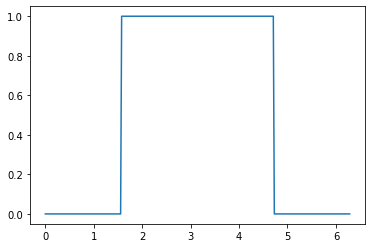

In [683]:
I = np.linspace(0,2.0*np.pi,500)
degree = 3
u = u_inicial(u0,degree)
x = np.linspace(0,2.0*np.pi,300)
current_sol = np.zeros(len(x))
for j in range(len(x)):
  current_sol[j] = u_reconstruct(x[j],I,u,degree)
#plt.axis('equal')
plt.plot(x,current_sol)
plt.show

Procedemos a resolver el problema

<function matplotlib.pyplot.show>

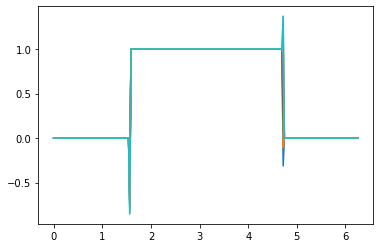

In [684]:
solution = solve_DG(I,fun,D_fun,u0,degree,n,dt)
x = np.linspace(0,2.0*np.pi,250)
current_sol = np.zeros(len(x))
for i in range(len(solution)):
  for j in range(len(x)):
    current_sol[j] = u_reconstruct(x[j],I,solution[i],degree)
  #plt.axis('equal')
  plt.plot(x[0:-1],current_sol[0:-1])  
plt.show

Para el caso de la ecuación de transporte, utilizamos una condición inicial discontinua en $\pi/2$ y $3\pi/2$. Notamos ondas de choque en las discontinuidades, apenas perceptibles en las gráficas con distinto color.

A continuación consideramos otro ejemplo en la ecuación de Burgers con una condición de frontera periódica.

In [687]:
def fun(x):
  return 0.5*x**2

def D_fun(x):
  return x

def u0(x):
  return 0.25 + 0.5 * np.sin(np.pi*(2.0*x-1.0))

n = 10
dt = 1.5/n

<function matplotlib.pyplot.show>

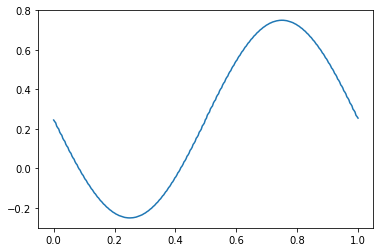

In [688]:
I = np.linspace(0,1,500)
degree = 3
u = u_inicial(u0,degree)
x = np.linspace(0,1,300)
current_sol = np.zeros(len(x))
for j in range(len(x)):
  current_sol[j] = u_reconstruct(x[j],I,u,degree)
#plt.axis('equal')
plt.plot(x,current_sol)
plt.show

<function matplotlib.pyplot.show>

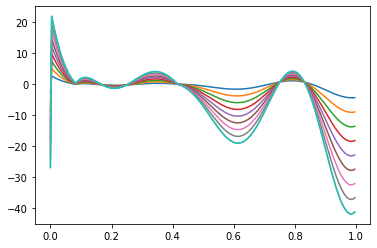

In [689]:
solution = solve_DG(I,fun,D_fun,u0,degree,n,dt)
x = np.linspace(0,1,250)
current_sol = np.zeros(len(x))
for i in range(len(solution)):
  for j in range(len(x)):
    current_sol[j] = u_reconstruct(x[j],I,solution[i],degree)
  #plt.axis('equal')
  plt.plot(x[0:-1],current_sol[0:-1])  
plt.show